<a href="https://colab.research.google.com/github/zp2226/E4511-2021-Zhanbo/blob/main/RF_Classification%26Peer_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

!pip install hyperopt

# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

TensorFlow 1.x selected.
--2021-04-29 15:27:04--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   108MB/s    in 4.6s    

2021-04-29 15:27:09 (110 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
   

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-fo

In [2]:
! pip install bravado

  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.whl size=18120 sha256=3a175f530515d245facc808e2079d2293fb2ab4db472fb213cc3d1a21c9bd442
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339


In [3]:
# There is a problem with the previously imported cffi, so delete it and load it with AMPL instead
#if 'cffi' in sys.modules:
#  del sys.modules['cffi']
#import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import model_pipeline as mp
import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [4]:
! wget https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/Data/DRD22_Merge.csv

--2021-04-29 15:37:07--  https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/Data/DRD22_Merge.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245572 (240K) [text/plain]
Saving to: ‘DRD22_Merge.csv’

DRD22_Merge.csv     100%[===================>] 239.82K  --.-KB/s    in 0.03s   

2021-04-29 15:37:07 (7.45 MB/s) - ‘DRD22_Merge.csv’ saved [245572/245572]



In [5]:
import pandas as pd
df = pd.read_csv('DRD22_Merge.csv', index_col=0)
df[df.compound_id.duplicated(keep=False)==True].sort_values(by='compound_id')
df_grouped = df.groupby('compound_id', as_index=False)['VALUE_NUM_mean'].mean()
df_dedup = df.drop_duplicates('compound_id')
df_avg = df_dedup.merge(df_grouped, left_on='compound_id', right_on='compound_id')
df_avg.drop('VALUE_NUM_mean_x', axis=1, inplace=True)
df_avg.rename(columns={'VALUE_NUM_mean_y': 'VALUE_NUM_mean'}, inplace=True)
df = df_avg


In [6]:
df.to_csv('DRD2_Merge_1.csv')

In [7]:
working_dir = '/content'
# data splits based on the scaffold of small molecules.
featurizer = 'ecfp' 
model_type = 'RF'
response_col = 'active'
smiles_col = 'base_rdkit_smiles'
compound_id = 'compound_id'
train_file = 'DRD2_Merge_1.csv'
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",   #Boolean flag for using an input file from the LLNL specific datastore system based on a key of dataset_key
        "save_results": "False", # Save model results to MongoDB,
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",  # Boolean flag for loading in previously split train, validation, and test csv files
        "split_only": "True",   # indicate splitting of the datasets when running the hyperparameter search
        'split_strategy':'train_valid_test',
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": working_dir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-04-29 15:37:22,360 Splitting data by scaffold


number of features: 1024


2021-04-29 15:37:24,528 Dataset split table saved to /DRD2_Merge_1_train_valid_test_scaffold_9bddbd1d-438a-439b-8179-047674bf7ebc.csv


In [8]:
split_uuid = pl.split_dataset()
split_uuid

2021-04-29 15:37:38,741 Splitting data by scaffold


number of features: 1024


2021-04-29 15:37:40,940 Dataset split table saved to /DRD2_Merge_1_train_valid_test_scaffold_1be7bf19-82d5-4d3f-918e-1238584decc4.csv


'1be7bf19-82d5-4d3f-918e-1238584decc4'

In [9]:
# train inital rf model
response_col = "active"
# default : rf_estimators=500, rf_max_features = 32
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,   # UUID for csv file containing train, validation, and test split information
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-29 15:37:55,812 Previous dataset split restored
2021-04-29 15:38:01,602 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/ea1ddd91-fc9a-44ce-bf39-a9ed2af37002/model_metadata.json
2021-04-29 15:38:01,855 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/ea1ddd91-fc9a-44ce-bf39-a9ed2af37002/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_ea1ddd91-fc9a-44ce-bf39-a9ed2af37002.tar.gz


In [10]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['roc_auc_score']:.3f}")

R2 score of validation set: 0.904


In [11]:
pred_data = pl.model_wrapper.get_perf_data(subset="test", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of test set: {pred_results['roc_auc_score']:.3f}")

R2 score of test set: 0.816


In [12]:
# Adding uncertainty to base training model
# The glob module finds all the pathnames matching a specified pattern according to the rules
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",       #Random forest
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',      # Maximum number of training epochs to run for DNN models. Default 30.
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"  # Boolean flag for computing uncertainty estimates for regression model predictions. 
    }

In [13]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-29 15:38:16,854 Previous dataset split restored
2021-04-29 15:38:22,608 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/02931dce-38d1-4c33-b5e4-577d3053cf7b/model_metadata.json
2021-04-29 15:38:22,859 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/02931dce-38d1-4c33-b5e4-577d3053cf7b/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_02931dce-38d1-4c33-b5e4-577d3053cf7b.tar.gz


In [14]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['roc_auc_score']:.3f}")

R2 score of validation set: 0.907


In [15]:
#GRID SEARCH
n_estimator = [100,300,500]
rf_max_depth = [50,150,300]
rf_max_features = [10,50,100]
rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['roc_auc_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

number of features: 1024


2021-04-29 15:38:37,760 Previous dataset split restored
2021-04-29 15:38:39,656 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/796a4ffc-46f1-49ca-9e6b-8dbd9384336d/model_metadata.json
2021-04-29 15:38:39,724 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/796a4ffc-46f1-49ca-9e6b-8dbd9384336d/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_796a4ffc-46f1-49ca-9e6b-8dbd9384336d.tar.gz
rf_estimators: 100, rf_max_depth: 50, rf_max_features: 10, valid_r2: 0.9037918296392872
number of features: 1024


2021-04-29 15:38:54,515 Previous dataset split restored
2021-04-29 15:38:56,693 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/8bacdeb3-8036-4664-aeed-48307d127c3a/model_metadata.json
2021-04-29 15:38:56,745 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/8bacdeb3-8036-4664-aeed-48307d127c3a/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_8bacdeb3-8036-4664-aeed-48307d127c3a.tar.gz
rf_estimators: 100, rf_max_depth: 50, rf_max_features: 50, valid_r2: 0.9110169491525423
number of features: 1024


2021-04-29 15:39:11,629 Previous dataset split restored
2021-04-29 15:39:14,319 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/1a384d5c-1ffd-423d-86d8-ed3db951be77/model_metadata.json
2021-04-29 15:39:14,368 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/1a384d5c-1ffd-423d-86d8-ed3db951be77/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_1a384d5c-1ffd-423d-86d8-ed3db951be77.tar.gz
rf_estimators: 100, rf_max_depth: 50, rf_max_features: 100, valid_r2: 0.9031399391568883
number of features: 1024


2021-04-29 15:39:29,191 Previous dataset split restored
2021-04-29 15:39:31,099 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/aa0e2eb5-a911-4a0f-af42-391217f69cea/model_metadata.json
2021-04-29 15:39:31,168 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/aa0e2eb5-a911-4a0f-af42-391217f69cea/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_aa0e2eb5-a911-4a0f-af42-391217f69cea.tar.gz
rf_estimators: 100, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.9080291177748805
number of features: 1024


2021-04-29 15:39:46,019 Previous dataset split restored
2021-04-29 15:39:48,190 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/5d42549d-ee2a-40b9-b2ef-48a0e902261c/model_metadata.json
2021-04-29 15:39:48,239 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/5d42549d-ee2a-40b9-b2ef-48a0e902261c/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_5d42549d-ee2a-40b9-b2ef-48a0e902261c.tar.gz
rf_estimators: 100, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.9089526292916125
number of features: 1024


2021-04-29 15:40:03,029 Previous dataset split restored
2021-04-29 15:40:05,706 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/17a1e74c-7bf2-42b5-8ad0-1bcc74893dd5/model_metadata.json
2021-04-29 15:40:05,751 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/17a1e74c-7bf2-42b5-8ad0-1bcc74893dd5/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_17a1e74c-7bf2-42b5-8ad0-1bcc74893dd5.tar.gz
rf_estimators: 100, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.9019448066058235
number of features: 1024


2021-04-29 15:40:20,409 Previous dataset split restored
2021-04-29 15:40:22,311 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/21a59928-de97-423a-a650-fac5d75c7eb3/model_metadata.json
2021-04-29 15:40:22,383 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/21a59928-de97-423a-a650-fac5d75c7eb3/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_21a59928-de97-423a-a650-fac5d75c7eb3.tar.gz
rf_estimators: 100, rf_max_depth: 300, rf_max_features: 10, valid_r2: 0.8882007822685789
number of features: 1024


2021-04-29 15:40:37,173 Previous dataset split restored
2021-04-29 15:40:39,449 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/f6ccd2cb-0a7c-4e4d-acfe-28b2b32e91bb/model_metadata.json
2021-04-29 15:40:39,508 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/f6ccd2cb-0a7c-4e4d-acfe-28b2b32e91bb/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_f6ccd2cb-0a7c-4e4d-acfe-28b2b32e91bb.tar.gz
rf_estimators: 100, rf_max_depth: 300, rf_max_features: 50, valid_r2: 0.9059647979139505
number of features: 1024


2021-04-29 15:40:54,272 Previous dataset split restored
2021-04-29 15:40:56,926 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/aa1f6081-a824-4503-928e-6cdbb5b72b94/model_metadata.json
2021-04-29 15:40:56,977 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/aa1f6081-a824-4503-928e-6cdbb5b72b94/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_aa1f6081-a824-4503-928e-6cdbb5b72b94.tar.gz
rf_estimators: 100, rf_max_depth: 300, rf_max_features: 100, valid_r2: 0.9025423728813559
number of features: 1024


2021-04-29 15:41:11,797 Previous dataset split restored
2021-04-29 15:41:15,349 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/a437e7db-fe2c-4144-9aa2-85fbe8c1d826/model_metadata.json
2021-04-29 15:41:15,545 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/a437e7db-fe2c-4144-9aa2-85fbe8c1d826/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_a437e7db-fe2c-4144-9aa2-85fbe8c1d826.tar.gz
rf_estimators: 300, rf_max_depth: 50, rf_max_features: 10, valid_r2: 0.9075945241199478
number of features: 1024


2021-04-29 15:41:30,285 Previous dataset split restored
2021-04-29 15:41:34,719 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/583e4028-0d83-424e-ab92-0102a2fd9b53/model_metadata.json
2021-04-29 15:41:34,856 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/583e4028-0d83-424e-ab92-0102a2fd9b53/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_583e4028-0d83-424e-ab92-0102a2fd9b53.tar.gz
rf_estimators: 300, rf_max_depth: 50, rf_max_features: 50, valid_r2: 0.9106366797044763
number of features: 1024


2021-04-29 15:41:49,763 Previous dataset split restored
2021-04-29 15:41:55,482 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/9ddf2b29-6d4f-4922-92fa-0ccb5a48f6cf/model_metadata.json
2021-04-29 15:41:55,600 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/9ddf2b29-6d4f-4922-92fa-0ccb5a48f6cf/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_9ddf2b29-6d4f-4922-92fa-0ccb5a48f6cf.tar.gz
rf_estimators: 300, rf_max_depth: 50, rf_max_features: 100, valid_r2: 0.9054758800521514
number of features: 1024


2021-04-29 15:42:10,491 Previous dataset split restored
2021-04-29 15:42:14,225 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/851df34e-8e96-44fb-9678-57fe9cdd2c3b/model_metadata.json
2021-04-29 15:42:14,429 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/851df34e-8e96-44fb-9678-57fe9cdd2c3b/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_851df34e-8e96-44fb-9678-57fe9cdd2c3b.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.9011299435028248
number of features: 1024


2021-04-29 15:42:29,293 Previous dataset split restored
2021-04-29 15:42:33,747 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/b7d0fe7b-64d2-4a1c-9478-672e28ee5087/model_metadata.json
2021-04-29 15:42:33,884 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/b7d0fe7b-64d2-4a1c-9478-672e28ee5087/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_b7d0fe7b-64d2-4a1c-9478-672e28ee5087.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.9023250760538896
number of features: 1024


2021-04-29 15:42:48,730 Previous dataset split restored
2021-04-29 15:42:54,428 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/cbbe399b-2f62-4b20-800c-fa30a71390f9/model_metadata.json
2021-04-29 15:42:54,554 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/cbbe399b-2f62-4b20-800c-fa30a71390f9/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_cbbe399b-2f62-4b20-800c-fa30a71390f9.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.9051499348109516
number of features: 1024


2021-04-29 15:43:09,411 Previous dataset split restored
2021-04-29 15:43:12,989 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/1a1cd962-0100-4338-96a5-614c3b7a58ce/model_metadata.json
2021-04-29 15:43:13,187 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/1a1cd962-0100-4338-96a5-614c3b7a58ce/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_1a1cd962-0100-4338-96a5-614c3b7a58ce.tar.gz
rf_estimators: 300, rf_max_depth: 300, rf_max_features: 10, valid_r2: 0.9023794002607562
number of features: 1024


2021-04-29 15:43:27,924 Previous dataset split restored
2021-04-29 15:43:32,236 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/df98fe8e-c5d5-4256-b470-a382113c0e29/model_metadata.json
2021-04-29 15:43:32,369 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/df98fe8e-c5d5-4256-b470-a382113c0e29/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_df98fe8e-c5d5-4256-b470-a382113c0e29.tar.gz
rf_estimators: 300, rf_max_depth: 300, rf_max_features: 50, valid_r2: 0.9047696653628858
number of features: 1024


2021-04-29 15:43:47,213 Previous dataset split restored
2021-04-29 15:43:52,933 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/705f6e89-f645-41b9-ba5d-a2fb2e40a807/model_metadata.json
2021-04-29 15:43:53,053 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/705f6e89-f645-41b9-ba5d-a2fb2e40a807/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_705f6e89-f645-41b9-ba5d-a2fb2e40a807.tar.gz
rf_estimators: 300, rf_max_depth: 300, rf_max_features: 100, valid_r2: 0.9078118209474142
number of features: 1024


2021-04-29 15:44:07,568 Previous dataset split restored
2021-04-29 15:44:12,284 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/c503303b-67cd-44e3-b73e-1d8764cc0c6b/model_metadata.json
2021-04-29 15:44:12,607 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/c503303b-67cd-44e3-b73e-1d8764cc0c6b/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_c503303b-67cd-44e3-b73e-1d8764cc0c6b.tar.gz
rf_estimators: 500, rf_max_depth: 50, rf_max_features: 10, valid_r2: 0.905638852672751
number of features: 1024


2021-04-29 15:44:27,318 Previous dataset split restored
2021-04-29 15:44:33,717 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/de77cf91-1c3d-4e9a-94a3-91baf129d5a8/model_metadata.json
2021-04-29 15:44:33,943 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/de77cf91-1c3d-4e9a-94a3-91baf129d5a8/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_de77cf91-1c3d-4e9a-94a3-91baf129d5a8.tar.gz
rf_estimators: 500, rf_max_depth: 50, rf_max_features: 50, valid_r2: 0.9097674923946111
number of features: 1024


2021-04-29 15:44:48,611 Previous dataset split restored
2021-04-29 15:44:57,267 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/5c8b3d57-ced2-4cee-bfc6-e06cfc3c442c/model_metadata.json
2021-04-29 15:44:57,459 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/5c8b3d57-ced2-4cee-bfc6-e06cfc3c442c/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_5c8b3d57-ced2-4cee-bfc6-e06cfc3c442c.tar.gz
rf_estimators: 500, rf_max_depth: 50, rf_max_features: 100, valid_r2: 0.9048783137766189
number of features: 1024


2021-04-29 15:45:12,196 Previous dataset split restored
2021-04-29 15:45:17,186 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/fbc4c812-c8d3-4f17-bbf8-8fddce730adf/model_metadata.json
2021-04-29 15:45:17,505 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/fbc4c812-c8d3-4f17-bbf8-8fddce730adf/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_fbc4c812-c8d3-4f17-bbf8-8fddce730adf.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.9042264232942199
number of features: 1024


2021-04-29 15:45:32,153 Previous dataset split restored
2021-04-29 15:45:38,413 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/02feb719-cd3d-4cc1-8016-7a7be9b2a2f8/model_metadata.json
2021-04-29 15:45:38,630 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/02feb719-cd3d-4cc1-8016-7a7be9b2a2f8/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_02feb719-cd3d-4cc1-8016-7a7be9b2a2f8.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.9079204693611473
number of features: 1024


2021-04-29 15:45:53,314 Previous dataset split restored
2021-04-29 15:46:01,877 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/fe7291e1-4adf-43e9-8869-3936b148a023/model_metadata.json
2021-04-29 15:46:02,063 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/fe7291e1-4adf-43e9-8869-3936b148a023/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_fe7291e1-4adf-43e9-8869-3936b148a023.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.9073772272924815
number of features: 1024


2021-04-29 15:46:16,663 Previous dataset split restored
2021-04-29 15:46:21,513 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/cbe54027-660b-4866-b206-a3159eb9be0a/model_metadata.json
2021-04-29 15:46:21,838 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/cbe54027-660b-4866-b206-a3159eb9be0a/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_cbe54027-660b-4866-b206-a3159eb9be0a.tar.gz
rf_estimators: 500, rf_max_depth: 300, rf_max_features: 10, valid_r2: 0.9056931768796176
number of features: 1024


2021-04-29 15:46:36,570 Previous dataset split restored
2021-04-29 15:46:43,123 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/f514b990-4ea9-43c6-82e2-a45e998e7860/model_metadata.json
2021-04-29 15:46:43,338 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/f514b990-4ea9-43c6-82e2-a45e998e7860/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_f514b990-4ea9-43c6-82e2-a45e998e7860.tar.gz
rf_estimators: 500, rf_max_depth: 300, rf_max_features: 50, valid_r2: 0.9084637114298131
number of features: 1024


2021-04-29 15:46:57,971 Previous dataset split restored
2021-04-29 15:47:06,499 Wrote model metadata to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/a23a1e57-e983-45f5-9689-8d30f414044e/model_metadata.json
2021-04-29 15:47:06,685 Wrote model metrics to file ampl_output/DRD2_Merge_1/RF_ecfp_scaffold_classification/a23a1e57-e983-45f5-9689-8d30f414044e/model_metrics.json


Wrote model tarball to ampl_output/DRD2_Merge_1_model_a23a1e57-e983-45f5-9689-8d30f414044e.tar.gz
rf_estimators: 500, rf_max_depth: 300, rf_max_features: 100, valid_r2: 0.9024880486744893


In [16]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_auc_roc_score": valid_r2_list})
perf_df.sort_values(by="valid_auc_roc_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_auc_roc_score
1,100,50,50,0.911017
10,300,50,50,0.910637
19,500,50,50,0.909767
4,100,150,50,0.908953
25,500,300,50,0.908464
3,100,150,10,0.908029
22,500,150,50,0.907920
17,300,300,100,0.907812
9,300,50,10,0.907595
23,500,150,100,0.907377


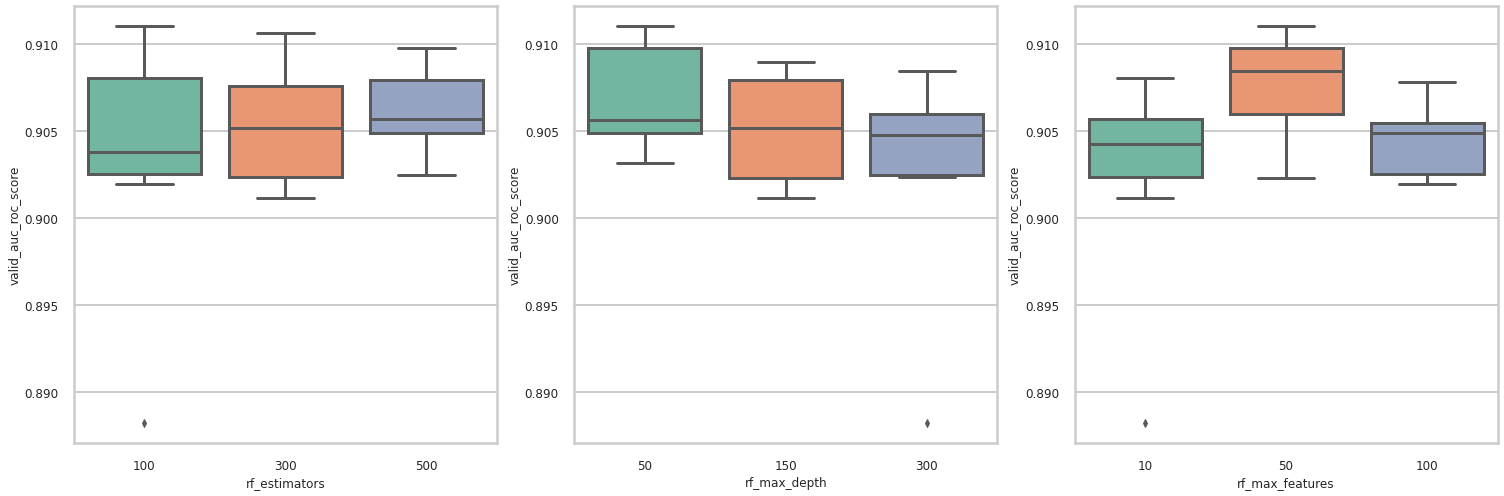

In [17]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_auc_roc_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_auc_roc_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_auc_roc_score", ax=ax[2])
fig.tight_layout()

In [18]:
#REDINED
cmp.get_filesystem_perf_results('ampl_output', pred_type='classification').sort_values(by='valid_roc_auc_score', ascending=False)

Found data for 29 models under ampl_output


,model_uuid,ampl_version,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_choice_score,train_roc_auc_score,train_prc_auc_score,train_precision,train_recall_score,train_num_compounds,train_accuracy_score,train_bal_accuracy,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,train_confusion_matrix,valid_roc_auc_score,valid_prc_auc_score,valid_precision,valid_recall_score,valid_num_compounds,valid_accuracy_score,valid_bal_accuracy,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,valid_confusion_matrix,test_roc_auc_score,test_prc_auc_score,test_precision,test_recall_score,test_num_compounds,test_accuracy_score,test_bal_accuracy,test_npv,test_matthews_cc,test_kappa,test_cross_entropy,test_confusion_matrix
4,8bacdeb3-8036-4664-aeed-48307d127c3a,1.1.0,RF,DRD2_Merge_1.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,100,50,50.0,NaN,NaN,0.911017,0.999179,0.998732,0.975839,0.991814,1834,0.986914,0.987733,0.994490,0.972894,0.972804,0.118607,"[[[1083, 18], [6, 727]]]",0.911017,0.806201,0.645161,0.769231,229,0.851528,0.822468,0.928144,0.608067,0.603927,0.390485,"[[[155, 22], [12, 40]]]",0.819728,0.772433,0.657895,0.765306,230,0.730435,0.734926,0.801724,0.464707,0.460176,0.523397,"[[[93, 39], [23, 75]]]"
22,583e4028-0d83-424e-ab92-0102a2fd9b53,1.1.0,RF,DRD2_Merge_1.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,300,50,50.0,NaN,NaN,0.910637,0.999365,0.999010,0.979702,0.987722,1834,0.986914,0.987049,0.991781,0.972790,0.972767,0.118662,"[[[1086, 15], [9, 724]]]",0.910637,0.818400,0.637931,0.711538,229,0.842795,0.796447,0.912281,0.571154,0.569684,0.499703,"[[[156, 21], [15, 37]]]",0.811727,0.748633,0.663636,0.744898,230,0.730435,0.732297,0.791667,0.459926,0.457382,0.530312,"[[[95, 37], [25, 73]]]"
21,de77cf91-1c3d-4e9a-94a3-91baf129d5a8,1.1.0,RF,DRD2_Merge_1.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,500,50,50.0,NaN,NaN,0.909767,0.999379,0.999036,0.975839,0.991814,1834,0.986914,0.987733,0.994490,0.972894,0.972804,0.118732,"[[[1083, 18], [6, 727]]]",0.909767,0.817872,0.661017,0.750000,229,0.855895,0.818503,0.923529,0.610213,0.608100,0.378164,"[[[157, 20], [13, 39]]]",0.815592,0.760769,0.691589,0.755102,230,0.752174,0.752551,0.804878,0.500766,0.499198,0.526023,"[[[99, 33], [24, 74]]]"
0,5d42549d-ee2a-40b9-b2ef-48a0e902261c,1.1.0,RF,DRD2_Merge_1.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,100,50,150.0,NaN,NaN,0.908953,0.999328,0.998964,0.977120,0.990450,1834,0.986914,0.987505,0.993584,0.972854,0.972792,0.118237,"[[[1084, 17], [7, 726]]]",0.908953,0.808518,0.644068,0.730769,229,0.847162,0.806063,0.917647,0.586379,0.584349,0.499528,"[[[156, 21], [14, 38]]]",0.815322,0.763811,0.648148,0.714286,230,0.713043,0.713203,0.770492,0.422506,0.420876,0.529650,"[[[94, 38], [28, 70]]]"
2,f514b990-4ea9-43c6-82e2-a45e998e7860,1.1.0,RF,DRD2_Merge_1.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,500,50,300.0,NaN,NaN,0.908464,0.999387,0.999049,0.979702,0.987722,1834,0.986914,0.987049,0.991781,0.972790,0.972767,0.118175,"[[[1086, 15], [9, 724]]]",0.908464,0.809312,0.649123,0.711538,229,0.847162,0.799272,0.912791,0.579940,0.578889,0.371179,"[[[157, 20], [15, 37]]]",0.816288,0.759463,0.669725,0.744898,230,0.734783,0.736085,0.793388,0.467620,0.465442,0.526433,"[[[96, 36], [25, 73]]]"
26,aa0e2eb5-a911-4a0f-af42-391217f69cea,1.1.0,RF,DRD2_Merge_1.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,100,10,150.0,NaN,NaN,0.908029,0.999293,0.998902,0.983629,0.983629,1834,0.986914,0.986365,0.989101,0.972730,0.972730,0.123796,"[[[1089, 12], [12, 721]]]",0.908029,0.808962,0.735849,0.750000,229,0.882096,0.835452,0.926136,0.666430,0.666379,0.391745,"[[[163, 14], [13, 39]]]",0.819921,0.738782,0.711538,0.755102,230,0.765217,0.763915,0.809524,0.524435,0.523700,0.653759,"[[[102, 30], [24, 74]]]"
23,02feb719-cd3d-4cc1-8016-7a

In [19]:
model_class =cmp.copy_best_filesystem_models(pred_type="classification", dest_dir=working_dir, 
                                result_dir='ampl_output', force_update=False)
model_class.to_csv('RF_Binary_model.csv')

Found data for 29 models under ampl_output
Copied DRD2_Merge_1_model_8bacdeb3-8036-4664-aeed-48307d127c3a.tar.gz


In [20]:
cmp.copy_best_filesystem_models(pred_type="classification", dest_dir=working_dir, 
                                result_dir='ampl_output', force_update=False)

Found data for 29 models under ampl_output


,model_uuid,ampl_version,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_choice_score,train_roc_auc_score,train_prc_auc_score,train_precision,train_recall_score,train_num_compounds,train_accuracy_score,train_bal_accuracy,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,train_confusion_matrix,valid_roc_auc_score,valid_prc_auc_score,valid_precision,valid_recall_score,valid_num_compounds,valid_accuracy_score,valid_bal_accuracy,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,valid_confusion_matrix,test_roc_auc_score,test_prc_auc_score,test_precision,test_recall_score,test_num_compounds,test_accuracy_score,test_bal_accuracy,test_npv,test_matthews_cc,test_kappa,test_cross_entropy,test_confusion_matrix
4,8bacdeb3-8036-4664-aeed-48307d127c3a,1.1.0,RF,DRD2_Merge_1.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,100,50,50.0,NaN,NaN,0.911017,0.999179,0.998732,0.975839,0.991814,1834,0.986914,0.987733,0.99449,0.972894,0.972804,0.118607,"[[[1083, 18], [6, 727]]]",0.911017,0.806201,0.645161,0.769231,229,0.851528,0.822468,0.928144,0.608067,0.603927,0.390485,"[[[155, 22], [12, 40]]]",0.819728,0.772433,0.657895,0.765306,230,0.730435,0.734926,0.801724,0.464707,0.460176,0.523397,"[[[93, 39], [23, 75]]]"


In [21]:
! pip install molvs

In [22]:
from atomsci.ddm.pipeline import predict_from_model

In [23]:
#Pei data
! wget https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_cur.csv

--2021-04-29 15:47:10--  https://raw.githubusercontent.com/ranpei97/E4511-2021-Pei/main/HTR2A_cur.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343123 (335K) [text/plain]
Saving to: ‘HTR2A_cur.csv’

HTR2A_cur.csv       100%[===================>] 335.08K  --.-KB/s    in 0.04s   

2021-04-29 15:47:10 (8.32 MB/s) - ‘HTR2A_cur.csv’ saved [343123/343123]



In [24]:
df_test = pd.read_csv('HTR2A_cur.csv',index_col=0)
df_test

,index,compound_id,base_rdkit_smiles,relation,pXC50,active,VALUE_NUM_std,Perc_Var,mol_wt,VALUE_NUM_mean
483,497,CHEMBL4171368,CCC[C@@H](CCO)Nc1nc(N)nc2cc(OC)ccc12,NaN,5.749580,0,NaN,0.0,290.174276,5.749580
876,898,CHEMBL3600828,Clc1ccc(-c2ccc(C#Cc3ccc(OCCN4CCCC4)cc3)nc2)cc1,NaN,6.301030,0,0.0,0.0,402.149891,6.301030
851,872,CHEMBL178870,Nc1ccc(S(=O)(=O)n2cc(C3CCNCC3)c3ccc(Cl)cc32)cc1,NaN,6.270000,0,NaN,0.0,389.096476,6.270000
1432,1459,CHEMBL74766,c1ccc2c(c1)Cc1ccccc1C21CCCNC1,NaN,7.000000,0,NaN,0.0,249.151750,7.000000
1012,1038,44287208,Clc1cccc2cc3n(c12)CCNC3,NaN,6.481490,0,NaN,0.0,206.061076,6.481490
...,...,...,...,...,...,...,...,...,...,...
1586,1615,CHEMBL4209705,CCNC(=O)c1ccnc(OCCCCN2CCC(c3noc4cc(F)ccc34)CC2)c1,NaN,7.170696,1,NaN,0.0,440.222369,7.170696
1394,1421,CHEMBL187888,C[C@@H]1CNC[C@H]2Cc3ccc(C#N)cc3N12,NaN,6.960000,0,NaN,0.0,213.126597,6.960000
449,463,CHEMBL1643858,CC(=O)N(C)c1ccc(OC2CN(c3c4c(nc5ccnn35)CCNCC4)C...,NaN,5.690000,0,NaN,0.0,406.211724,5.690000
2398,2442,66801028,O=S(=O)(NCCCN1CCC(c2noc3cc(F)ccc23)CC1)c1ccc(O...,NaN,8.420220,1,NaN,0.0,501.134540,8.420220


In [25]:
df_test_nonoverlapping = df_test[~df_test.base_rdkit_smiles.isin(df.base_rdkit_smiles)]

In [27]:
test = predict_from_model.predict_from_model_file(model_path='DRD2_Merge_1_model_8bacdeb3-8036-4664-aeed-48307d127c3a.tar.gz',
                            input_df = df_test_nonoverlapping,
                            id_col='compound_id',
                            smiles_col='base_rdkit_smiles',
                            response_col='active',
                            is_featurized=False,
                            dont_standardize=True)

2021-04-29 15:50:23,535 ['ampl_version', 'time_generated', 'time_built', 'dataset_metadata', 'training_metrics'] are not part of the accepted list of parameters and will be ignored


Featurization = DynamicFeaturization with ecfp features
number of features: 1024


In [28]:
test

,compound_id,base_rdkit_smiles,active_actual,active_prob,active_pred
1602,10017556,CC(C)Oc1cc2c(cc1Br)C(C)CNCC2,1.0,0.218500,0
1235,10022781,O=C1c2ccoc2CCC1CCN1CCC(c2noc3cc(F)ccc23)CC1,1.0,0.810000,1
2189,10042602,Cc1cccc(N2CCN(CCc3ccc4nn[nH]c4c3)CC2)c1C,1.0,0.610000,1
2293,10064386,COc1cc2c(cc1I)C(C)CNCC2,1.0,0.230041,0
90,10088453,COc1ccccc1N1CCN(CCc2ccc3nn[nH]c3c2)CC1,0.0,0.560000,1
...,...,...,...,...,...
548,CHEMBL96471,c1ccc(C2CCN(CC3C[C@@H]4c5ccccc5Cc5ccccc5[C@H]4...,0.0,0.480000,0
118,CHEMBL96732,CN(C)CC1C[C@H]2c3ccccc3Cc3ccccc3[C@H]2O1,0.0,0.855000,1
2058,CHEMBL96883,CC(N)Cn1ccc2cc(F)ccc21,0.0,0.130000,0
2186,CHEMBL97450,CCCCCCCCCOc1ccc2[nH]cc(CCN)c2c1,0.0,0.480000,0


In [29]:
confusion = pd.crosstab(test.active_actual,test.active_pred,margins=True)
display(confusion)
print('accuracy is', (confusion.at[0,0]+confusion.at[1,1])/confusion.at['All','All'])

active_pred,0,1,All
active_actual,,,
0.0,1162,78,1240
1.0,867,331,1198
All,2029,409,2438


accuracy is 0.6123872026251025


In [34]:
from sklearn.metrics import r2_score, mean_squared_error,roc_auc_score,accuracy_score,recall_score,log_loss
#print(r2_score(test.new_active_actual, test.new_active_pred))
#print(mean_squared_error(test.new_active_actual, test.new_active_pred))
print(roc_auc_score(test.active_actual,test.active_pred))
print(accuracy_score(test.active_actual,test.active_pred))
print(recall_score(test.active_actual,test.active_pred))
1162/1240
print(log_loss(test.active_actual,test.active_pred))

0.6066952986159729
0.6123872026251025
0.27629382303839733
13.387697318207607


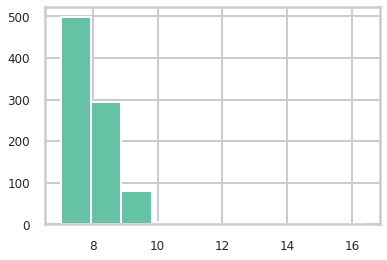

In [32]:

import matplotlib.pyplot as plt
plt.hist(df.loc[df.active==1]['VALUE_NUM_mean'], bins=10)
plt.show()